In [9]:
import base64
import io
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init

In [10]:
# Ensure every computation happens on the GPU when available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from datasets import load_dataset

img_size=96

def transforms_dataset(examples):
    examples["image"] = [image.convert("RGB").resize((96,96)) for image in examples["image"]]
    return examples


df = load_dataset("Erland/coco_captions_small")
df = df.map(transforms_dataset, batched=True)
df

DatasetDict({
    train: Dataset({
        features: ['image', 'filename', 'cocoid', 'caption'],
        num_rows: 5000
    })
})

In [32]:
from datasets import Dataset, DatasetDict

if isinstance(df, DatasetDict):
    df = df["train"]
if isinstance(df, Dataset):
    df = df.to_pandas()

df["b64string_images"] = df["image"].apply(lambda x: base64.b64encode(x["bytes"]).decode('utf-8'))
df

,image,filename,cocoid,caption,b64string_images
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000522418.jpg,522418,A woman wearing a net on her head cutting a ca...,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000522418.jpg,522418,A woman cutting a large white sheet cake.,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000522418.jpg,522418,A woman wearing a hair net cutting a large she...,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000522418.jpg,522418,there is a woman that is cutting a white cake,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000522418.jpg,522418,A woman marking a cake with the back of a chef...,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
...,...,...,...,...,...
4995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000495088.jpg,495088,A bird flies over the water near an island.,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
4996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000495088.jpg,495088,Seagull flying over a water way with an island...,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
4997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000495088.jpg,495088,A seagull flies over a grassy and rocky beach.,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...
4998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,COCO_val2014_000000460160.jpg,460160,a white bird some sand water rocks and grass,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAIAAABt+uBvAA...


In [13]:
#To build the encoding and decoding functions we use the tinyshakespear dataset. However for the sake of brevity we do not pretrain the decoder model on it
#the training function should be able to do it without an issue as well as it could take both images and text
text = "".join(df["train"].to_pandas()["caption"].tolist())

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
stoi['<pad>']= 65
itos = { i:ch for i,ch in enumerate(chars) }
itos[65] = '<pad>'
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
vocab_size = len(stoi.keys())

In [14]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size=96, patch_size=16, hidden_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        # Ensure the convolution outputs a feature map with hidden_dim channels
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        X = self.conv(X)
        X = X.flatten(2)  # Flatten the patch dimensions
        X = X.transpose(1, 2)  # [B, num_patches, hidden_dim]
        return X


In [15]:
#swapping linear for lazy linear for simplicity. Lazylinear can accept any arbitrary input dimension without having it specified

class MLP(nn.Module):
    def __init__(self, n_embd, dropout=0.1, is_decoder=True):
        super().__init__()
        layers = [
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU() if is_decoder else nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [16]:
class Head(nn.Module):
    def __init__(self, n_embd, head_size, dropout=0.1, is_decoder=False):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.is_decoder = is_decoder

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * (C**-0.5)
        if self.is_decoder:
            # Ensure the mask is the correct size for the current sequence length
            tril = torch.tril(torch.ones(T, T, dtype=torch.bool, device=device))
            wei = wei.masked_fill(tril == 0, float('-inf'))

        # Apply softmax to get probabilities
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Perform weighted aggregation of values
        out = wei @ v
        return out



In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()
        #Using assert statements for this type of checks is a good idea in general in your code
        assert n_embd % num_heads == 0, "n_embd must be divisible by num_heads"
        self.heads = nn.ModuleList([
            Head(n_embd, n_embd // num_heads, dropout, is_decoder)
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


In [18]:
class Block(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, num_heads, dropout, is_decoder)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        original_x = x  # Save for residual connection
        x = self.ln1(x)
        attn_output = self.attn(x)
        x = original_x + attn_output
        x = self.ln2(x)
        ffn_output = self.ffn(x)
        x = x + ffn_output
        return x


In [19]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()
        self.patch_embedding = PatchEmbeddings(img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blocks = nn.ModuleList([Block(num_hiddens, num_heads, blk_dropout, is_decoder=False) for _ in range(num_blks)])
        self.layer_norm = nn.LayerNorm(num_hiddens)

    def forward(self, X):
        x = self.patch_embedding(X)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.layer_norm(x[:, 0])
        return x


In [20]:
class MultiModalProjector(nn.Module):
    def __init__(self, n_embd, image_embed_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_embed_dim, 4 * image_embed_dim),
            nn.GELU(),
            nn.Linear(4 * image_embed_dim, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.net(x)
        return x


In [21]:
class DecoderLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=False):
        super().__init__()
        self.use_images = use_images
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(1000, n_embd)
        if use_images:
            self.image_projection = MultiModalProjector(n_embd, image_embed_dim)
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, is_decoder=True) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, image_embeds=None, targets=None):
        tok_emb = self.token_embedding_table(idx)
        if self.use_images and image_embeds is not None:
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            tok_emb = torch.cat([img_emb, tok_emb], dim=1)
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is not None:
            if self.use_images and image_embeds is not None:
                batch_size = idx.size(0)
                targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss
        return logits

    def generate(self, idx, image_embeds, max_new_tokens):
        B, T = idx.shape
        generated = idx

        if self.use_images and image_embeds is not None:
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)
        else:
            current_output = self.token_embedding_table(idx)

        for i in range(max_new_tokens):
            T_current = current_output.size(1)
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)
            current_output += current_pos_emb

            for block in self.blocks:
                current_output = block(current_output)

            logits = self.lm_head(current_output[:, -1, :])
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            generated = torch.cat((generated, idx_next), dim=1)
            idx_next_emb = self.token_embedding_table(idx_next)
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated


In [22]:
class VisionLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()
        num_hiddens = image_embed_dim  # Set num_hiddens equal to image_embed_dim
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"
        self.vision_encoder = ViT(img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout)
        self.decoder = DecoderLanguageModel(n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=True)

    def forward(self, img_array, idx, targets=None):
        image_embeds = self.vision_encoder(img_array)

        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("somethign is messed up with the ViT model. It's returning an empty tensor or the embedding dimension is empty")

        if targets is not None:
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            logits = self.decoder(idx, image_embeds)
            return logits

    def generate(self, img_array, idx, max_new_tokens):
      image_embeds = self.vision_encoder(img_array)

      if image_embeds.nelement() == 0 or image_embeds.shape[1] ==0:
        raise ValueError("somethign is messed up with the ViT model. It's returning an empty tensor or the embedding dimension is empty")

      generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
      return generated_tokens

In [23]:
def base64_to_tensor(base64_str, img_size=96):
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

In [24]:
import base64
from datasets import Dataset
#Adjusting the data loader from makemore for multimodal data
def get_batch(df, batch_size, split='train', img_size=96, val_batch_size=8):
    # Split data into training and validation sets
    if "image" in df:
        df["b64string_images"] = df["image"].apply(lambda x: base64.b64encode(x["bytes"]).decode('utf-8'))
    n = int(0.9 * len(df))  # first 90% will be train, rest val
    df_train = df.iloc[:n]
    df_val = df.iloc[n:]
    data = df_train if split == 'train' else df_val
    batch_size = batch_size if split == 'train' else val_batch_size
    replace = False if split == 'train' else True
    batch = data.sample(n=batch_size, replace=replace)  

    images = torch.cat([base64_to_tensor(img, img_size) for img in batch['b64string_images']], dim=0).to(device)
    text_indices = [torch.tensor(encode(desc), dtype=torch.long) for desc in batch['caption']]
    max_length = max(len(t) for t in text_indices)

    padded_text = torch.full((batch_size, max_length), fill_value=stoi['<pad>'], dtype=torch.long).to(device)
    for i, text in enumerate(text_indices):
        padded_text[i, :len(text)] = text

    targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=stoi['<pad>'], dtype=torch.long, device=device)], dim=1)

    # Truncate or pad targets to match the length of padded_text
    if targets.size(1) > padded_text.size(1):
        targets = targets[:, :padded_text.size(1)]
    elif targets.size(1) < padded_text.size(1):
        targets = torch.cat([targets, torch.full((batch_size, padded_text.size(1) - targets.size(1)), fill_value=stoi['<pad>'], dtype=torch.long, device=device)], dim=1)

    return images, padded_text, targets

In [25]:
from datasets import Dataset, DatasetDict
#Adjusting the training loop from makemore for multimodal data
def train_model(model, df, epochs, vocab_size, img_size=96):
    if isinstance(df, DatasetDict):
        df = df["train"]
    if isinstance(df, Dataset):
        df = df.to_pandas()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for _ in range(max_iters):
            images, idx, targets = get_batch(df, batch_size, 'train', img_size)
            optimizer.zero_grad()
            logits, loss = model(images, idx, targets)
            loss.backward()
            optimizer.step()
            if _ % eval_interval == 0:
                print(f"Loss at iteration {_}: {loss.item()}")
        val_loss = estimate_loss(model, df, 'val', img_size, val_batch_size=8)
        print(f"Validation Loss after epoch {epoch}: {val_loss}")

def estimate_loss(model, df, split, img_size=96, val_batch_size=8):
    losses = []
    model.eval()
    for _ in range(eval_iters):
        images, idx, targets = get_batch(df, batch_size, split, img_size, val_batch_size=val_batch_size)
        _, loss = model(images, idx, targets)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [26]:
# df = pd.read_csv("./images/inputs.csv")
# #Expanding dataframe so that there's enough data to test. This is just duplicating data. A real dataset would have more rows
# df = pd.concat([df] * 30)[['b64string_images', 'caption']]
# df

In [29]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
epochs=1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 40
num_blks= 3
head_size = 16
n_embd = 128
n_head = 8
n_layer = 8
dropout = 0.1
patch_size =16
image_embed_dim = 512
emb_dropout = blk_dropout =0.1

In [30]:
# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, n_head, num_blks, emb_dropout, blk_dropout)
model.to(device)

# Dummy data to initialize lazy modules
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)
model(dummy_img, dummy_idx)  # Forward pass to initialize all parameters

# Train the model
train_model(model, df, epochs, vocab_size, img_size)


Loss at iteration 0: 4.457466125488281
Loss at iteration 10: 1.9654109477996826
Loss at iteration 20: 1.81917405128479
Loss at iteration 30: 1.7808351516723633
Loss at iteration 40: 1.9613587856292725
Loss at iteration 50: 1.5628306865692139
Loss at iteration 60: 1.241055965423584
Loss at iteration 70: 1.853525161743164
Loss at iteration 80: 1.3078677654266357
Loss at iteration 90: 1.7591981887817383
Loss at iteration 100: 1.4118046760559082
Loss at iteration 110: 1.494604468345642
Loss at iteration 120: 1.3597708940505981
Loss at iteration 130: 1.4479448795318604
Loss at iteration 140: 1.2047079801559448
Loss at iteration 150: 1.8983746767044067
Loss at iteration 160: 1.487746000289917
Loss at iteration 170: 1.262772560119629
Loss at iteration 180: 1.052586317062378
Loss at iteration 190: 1.8553410768508911
Loss at iteration 200: 1.1981844902038574
Loss at iteration 210: 1.6544491052627563
Loss at iteration 220: 1.4200111627578735
Loss at iteration 230: 1.492863655090332
Loss at itera

In [44]:
images = torch.cat([base64_to_tensor(img, img_size) for img in [df['b64string_images'].iloc[0]]], dim=0).to(device)
text_indices = torch.tensor(encode(""), dtype=torch.long).unsqueeze(0).to("cuda")
model(images, text_indices[0].unsqueeze(0).to("cuda"))  # Forward pass to initialize all parameters

tensor([[[-1.7311,  5.2757, -0.4133, -1.1743, -1.1277, -1.7533, -1.8081,
          -0.9809, -0.9797, -1.3525, -1.2050, -0.4810, -0.2295, -2.3593,
          -0.5692, -0.7823, -1.2575, -0.9167, -0.8237, -0.5034, -0.9424,
          -1.1928, -1.2674, -1.5453, -1.7860, -0.4398, -0.8411, -2.0823,
          -0.6756, -0.7530, -1.4844, -1.2397, -1.1951, -0.4741, -1.9015,
          -1.2799, -1.4157, -1.9456, -0.9511, -1.5447, -0.3529,  0.0359,
           1.1332, -0.9679, -1.8003, -0.4798, -1.1702,  3.1647, -1.3321,
          -1.0094, -1.0182, -1.6907,  3.7277,  0.8723,  1.5402,  1.1272,
           0.8613,  3.8117,  1.6693, -1.1401, -1.3969, -2.8048, -0.7900,
          -1.5353, -1.3209, -1.0876]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

--- <pad> token generated at step 54. Stopping. ---
looking at the airplane on a skateboard near a phone.<pad>


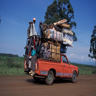

In [50]:
max_tokens = 100
# Add temperature for sampling. Higher values (e.g., 1.0) make the output more random,
# while lower values (e.g., 0.2) make it more focused and deterministic.
temperature = 0.5
index = 80

images = torch.cat([base64_to_tensor(img, img_size) for img in [df['b64string_images'].iloc[index]]], dim=0).to(device)
text_indices = torch.tensor(encode(""), dtype=torch.long).unsqueeze(0).to("cuda")
with torch.no_grad():  # Disable gradient calculations for efficiency
    for i in range(max_tokens):
        # Pass the image and the currently generated sequence to the model
        logits = model(images, text_indices)

        # We only need the logits for the very last token to predict the next one
        # logits shape: [batch_size, seq_len, vocab_size]
        last_token_logits = logits[:, -1, :]

        # --- Temperature Sampling ---
        # Scale logits by temperature. This sharpens or flattens the probability distribution.
        scaled_logits = last_token_logits / temperature

        # Apply softmax to the scaled logits to get a new probability distribution
        probs = torch.nn.functional.softmax(scaled_logits, dim=-1)

        # Sample from the probability distribution to get the next token
        next_token_index = torch.multinomial(probs, num_samples=1)
        # --- End Temperature Sampling ---

        # Append the predicted token to our sequence
        text_indices = torch.cat([text_indices, next_token_index], dim=1)

        # Check if the generated token is the padding token, which signals the end
        if next_token_index.item() == stoi['<pad>']:
            print(f"--- <pad> token generated at step {i+1}. Stopping. ---")
            break
    else:  # This 'else' belongs to the 'for' loop and executes if the loop finishes without a 'break'
        print(f"--- Max tokens ({max_tokens}) reached. Stopping. ---")

print(decode(text_indices[0].tolist()))

import base64
from PIL import Image
image_bytes = base64.b64decode(df['b64string_images'].iloc[index])
image_file = io.BytesIO(image_bytes)
image = Image.open(image_file)
image.show()


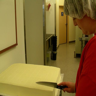

In [38]:
import base64
from PIL import Image
image_bytes = base64.b64decode(df['b64string_images'].iloc[4])
image_file = io.BytesIO(image_bytes)
image = Image.open(image_file)
image.show()

In [50]:
decode(text_indices[0].tolist())

' n antique iphone on a table<pad>'

In [48]:
print(text_indices)

tensor([[ 1, 52,  1, 39, 52, 58, 47, 55, 59, 43,  1, 47, 54, 46, 53, 52, 43,  1,
         53, 52,  1, 39,  1, 58, 39, 40, 50, 43, 65]], device='cuda:0')


tensor([[[-1.7311,  5.2757, -0.4133,  ..., -1.5353, -1.3209, -1.0876],
         [-1.7472,  6.0970, -0.7582,  ..., -1.4642, -1.1667, -0.9900],
         [-0.5693,  1.2513, -0.2370,  ..., -1.3210, -0.4063,  0.0685],
         ...,
         [ 0.2831,  0.5999, -0.6967,  ..., -0.5983, -0.0113,  1.3863],
         [-0.4364, -0.4496, -0.0433,  ..., -1.0106, -0.6957, -0.5579],
         [-0.3145,  0.4481, -0.6858,  ..., -0.8898, -1.6107,  9.4207]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [67]:
from datasets import load_dataset, Dataset
from itertools import islice
"""
Streams the jxie/coco_captions dataset, takes the first 500 examples,
and pushes them to a new repository on the Hugging Face Hub.
"""
# --- Dataset Configuration ---
original_repo = "jxie/coco_captions"
num_samples = 5000
split = 'train' # Assuming you want the 'train' split

# --- Hugging Face Hub Configuration ---
# !!! IMPORTANT: Replace with your Hugging Face username !!!
hf_username = "Erland"
hf_repo_name = "coco_captions_small"

print(f"Loading dataset '{original_repo}' in streaming mode...")

# 1. Load the dataset in streaming mode
streamed_dataset = load_dataset(original_repo, split=split, streaming=True)

# 2. Take the first N samples from the stream
print(f"Taking the first {num_samples} samples...")
subset_iterator = islice(streamed_dataset, num_samples)

# Load the subset into memory to create a standard Dataset
subset_list = list(subset_iterator)

# 3. Convert the list of dictionaries to a dictionary of lists
if not subset_list:
    print("No data was streamed from the dataset. Exiting.")
    exit(1)

keys = subset_list[0].keys()
data_dict = {key: [example[key] for example in subset_list] for key in keys}

# 4. Create a new Dataset object
print("Creating a new Dataset object from the subset...")
small_dataset = Dataset.from_dict(data_dict)

# 5. Push the new dataset to the Hugging Face Hub
print("\nPushing dataset to the Hugging Face Hub...")
print("Note: You must be logged in. Run 'huggingface-cli login' in your terminal if you haven't.")

if hf_username == "YOUR_HF_USERNAME" or not hf_username:
    print("\nERROR: Please open this script and set the 'hf_username' variable to your Hugging Face username.")
    exit(1)

hub_repo_id = f"{hf_username}/{hf_repo_name}"
print(f"Uploading to repository: {hub_repo_id}")

try:
    # You can add `private=True` to make the dataset private:
    # small_dataset.push_to_hub(hub_repo_id, private=True)
    small_dataset.push_to_hub(hub_repo_id)
    
    print("\nProcess complete!")
    print(f"Successfully pushed {len(small_dataset)} records to the Hub.")
    print(f"View your dataset at: https://huggingface.co/datasets/{hub_repo_id}")
except Exception as e:
    print(f"\nAn error occurred during upload: {e}")
    print("Please ensure you are logged in ('huggingface-cli login') and have write permissions for the repository.")

Loading dataset 'jxie/coco_captions' in streaming mode...


Resolving data files:   0%|          | 0/182 [00:00<?, ?it/s]

Taking the first 5000 samples...
Creating a new Dataset object from the subset...

Pushing dataset to the Hugging Face Hub...
Note: You must be logged in. Run 'huggingface-cli login' in your terminal if you haven't.
Uploading to repository: Erland/coco_captions_small


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            


Process complete!
Successfully pushed 5000 records to the Hub.
View your dataset at: https://huggingface.co/datasets/Erland/coco_captions_small


In [68]:
from datasets import load_dataset

dataset = load_dataset("Erland/coco_captions_small")
dataset

README.md:   0%|          | 0.00/387 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'filename', 'cocoid', 'caption'],
        num_rows: 5000
    })
})

In [ ]:
if isinstance(dataset, DatasetDict):
    dataset = dataset["train"]
if isinstance(dataset, Dataset):
    dataset = dataset.to_pandas()

dataset["b64string_images"] = dataset["image"].apply(lambda x: base64.b64encode(x["bytes"]).decode('utf-8'))
dataset

NameError: name 'dataset' is not defined

In [70]:
dataset["train"][0]["image"], dataset["train"][0]["caption"]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'A woman wearing a net on her head cutting a cake. ')